# ICR - Identifying Age-Related Conditions

* [Data](#section-data)
    * [Data train](#subsection-train-greeks)
* [Fill Missing Value using KNN imputer](#section-fms)
* [Feature Selection](#section-fs)
    * [Iteration - 1](#subsection-it1)
    * [Iteration - 2](#subsection-it2)
* [Modelling](#section-stf)
* [Modelling](#section-modelling)
    * [Modelling - 1](#subsection-m1)
    * [Modelling - 2](#subsection-m2)

Problem :
* imbalanced data -> using metric balanced log loss
* missing values -> knn imputer 
* feature selection 
   * correlation ratio for numerical features
   * Binning = numerical values -> categorical features
   * CramersV for categorical features
* Classification -> tensor flow decision forest
   * Random Forest Model
   * Gradient Boosted Trees Model

  

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.style as style

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id="section-data"></a>
## Data

#### Objective : The goal is to predict if a person has any of three medical conditions. 
* Create a model trained on measurements of health characteristics. 
* Observe the relationship between measurements of certain characteristics and potential patient conditions.

#### Target : 
* To predict  if the person has one or more of any of the three medical conditions (Class 1), or 
* none of the three medical conditions (Class 0). 

<a id="subsection-train-greeks"></a>
### Data train

In [3]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')

#### The training set.
* Id Unique identifier for each observation.
* AB-GL Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
* Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.

In [4]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [5]:
len(train)

617

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

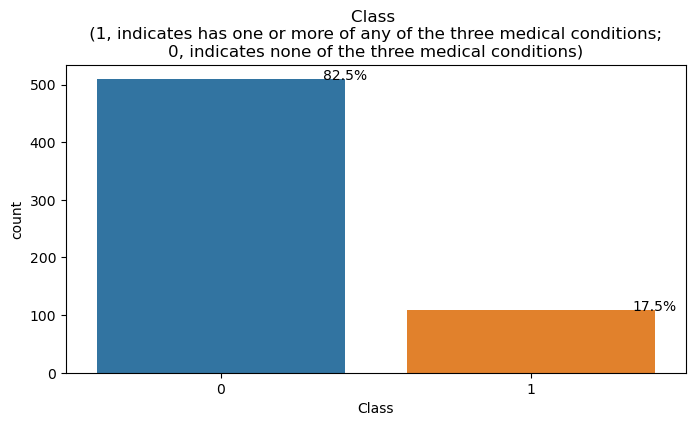

0    509
1    108
Name: Class, dtype: int64

In [7]:
# Class

plt.figure(figsize=(8,4))
total = float(len(train['Class']))
ax = sns.countplot(x='Class', data=train)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
plt.title('Class \n (1, indicates has one or more of any of the three medical conditions; \n0, indicates none of the three medical conditions)')
plt.show()
train.Class.value_counts()

From chart we can see the data train is imbalanced because the fraction of class 1 is very small compared with class 0

In [8]:
len(sample_submission)

5

<a id="section-fms"></a>
## Fill Missing Value using KNN Imputer

,Total missing data,Percentage
EL,60.0,9.724473
BQ,60.0,9.724473
CC,3.0,0.486224
FS,2.0,0.324149
CB,2.0,0.324149
FL,1.0,0.162075
FC,1.0,0.162075
DU,1.0,0.162075
GL,1.0,0.162075


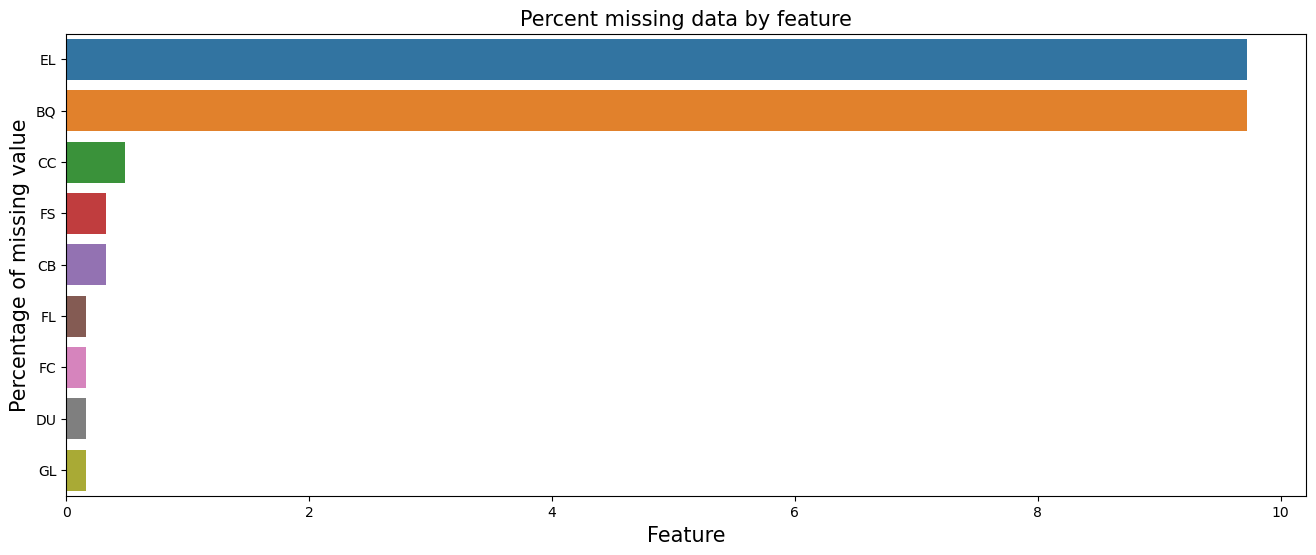

In [9]:
df = train

# Total missing data
total = df.isnull().sum().sort_values(ascending=False)

# Percentage missing data
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)

# Tabel Missing Data
missing_data = pd.concat([total, percent],axis=1, keys=['Total missing data', 'Percentage'])
tabel_md = missing_data[missing_data > 0].head(50).dropna()

# Graph Missing Data
fig, ax = plt.subplots(figsize=(16,6))
#plt.xticks(rotation='90')
sns.barplot(y=tabel_md.index, x=tabel_md['Percentage'])
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Percentage of missing value', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

tabel_md

Total missing data


1.   Column total missing data > 9% : EL & BQ
2.   Column total missing data < 1% : CC; CB; FS; FL; FC; DU; GL


In [10]:
# Code for check correlation between feature
# Before knn imputer, check correlation between features
df.corr()['EL'].sort_values(ascending=False, key=abs)[0:15]

/tmp/ipykernel_20/2383781487.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['EL'].sort_values(ascending=False, key=abs)[0:15]


EL     1.000000
GL     0.314225
GE     0.186231
CU     0.140361
CR    -0.135894
FE     0.134647
GI     0.126628
DI     0.123333
AZ     0.118017
AF     0.114897
AX     0.112591
EU     0.105477
CD    -0.104424
EG    -0.090724
DA    -0.089641
Name: EL, dtype: float64

Number of samples is small, so missing data will replace with KNN Imputer

In [11]:
# Using KNN imputer
from sklearn.impute import KNNImputer

#### Data Train

In [12]:
# We choose features which we assume is related to column that has missing data, the highest correlation
imp_el = df[['AF', 'AZ', 'CR', 'CU', 'DI', 'EL', 'FE','GE', 'GI', 'GL',]]
imputer = KNNImputer(n_neighbors=4,weights='distance')
imp_filled = imputer.fit_transform(imp_el)
imp_filled = pd.DataFrame(imp_filled, columns=imp_el.columns)

<Axes: ylabel='Frequency'>

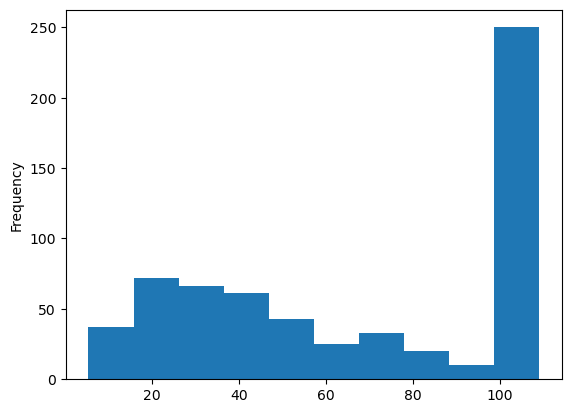

In [13]:
# EL after fill missing value
imp_filled['EL'].plot(kind='hist')

<Axes: ylabel='Frequency'>

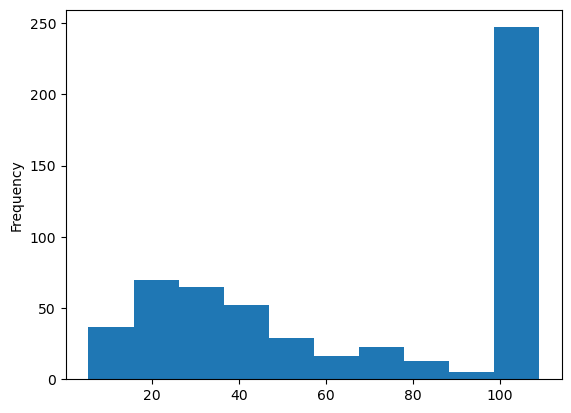

In [14]:
# EL before fill missing value
imp_el['EL'].plot(kind='hist')

The other column process for knn imputer will compare distribution before and after fill missing value

In [15]:
# Fill missing values in column EL
imp_idx = imp_el[(imp_el['EL'].isnull())].index.values
df['EL'] = imp_filled['EL']

In [16]:
# Knn imputer for column BQ, CC; CB; FS; FL; FC; DU; GL

# We choose features which we assume is related to column, the highest correlation
imp_bq = df[['BQ','AB', 'AF', 'AM', 'AR', 'AX', 'BP', 'CD ', 'CF', 'CH', 'DI', 'DN', 'EB', 'FL', 'GL']]
imp_cc = df[['CC', 'BZ', 'BC', 'BD ', 'CF', 'GB', 'AB', 'BR', 'BP', 'GE', 'AX']]
imp_cb = df[['CB', 'CD ', 'FC', 'GE', 'CR', 'BQ']]
imp_fs = df[['FS', 'DI', 'GL', 'DN', 'DA', 'CF', 'GF', 'DY']]
imp_fl = df[['FL', 'DU', 'EH', 'FD ', 'GL', 'DF', 'AM', 'GH', 'BQ']]
imp_fc = df[['FC', 'AB', 'AH', 'CH', 'BN', 'AX', 'CB', 'AZ', 'GB']]
imp_du = df[['DU', 'EH', 'FD ', 'FL', 'GL', 'EE', 'BQ', 'BN', 'AF', 'DN']]
imp_gl = df[['GL', 'GF', 'FL', 'EL', 'BQ', 'DU', 'DY', 'EE']]

list_corr_column = [imp_bq, imp_cc, imp_cb, imp_fs, imp_fl, imp_fc, imp_du, imp_gl]


# value n_neighbor for KNNImputer for column BQ, CC; CB; FS; FL; FC; DU; GL
neigh = [5, 4, 4, 3, 5, 5, 3, 4]


# list for indexing
list_index = [imp_bq['BQ'], imp_cc['CC'], imp_cb['CB'], imp_fs['FS'], imp_fl['FL'], imp_fc['FC'], imp_du['DU'], imp_gl['GL']]


list_ms = []
# looping for fill missing values in columns
for i in range(len(neigh)):
    imputer = KNNImputer(n_neighbors=neigh[i],weights='distance')
    imp_filled = imputer.fit_transform(list_corr_column[i])
    imp_filled = pd.DataFrame(imp_filled, columns=list_corr_column[i].columns)
    list_ms.append(imp_filled[imp_filled.columns[0]])

df['BQ'] = list_ms[0]
df['CC'] = list_ms[1]
df['CB'] = list_ms[2]
df['FS'] = list_ms[3]
df['FL'] = list_ms[4]
df['FC'] = list_ms[5]
df['DU'] = list_ms[6]
df['GL'] = list_ms[7]
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [17]:
train_knn_imputer = df

<a id="section-fs"></a>
## Feature Selection

In [18]:
import scipy.stats as ss

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(
        np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg),
                                      2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator / denominator)
    return eta

def cramers_v(x, y):
    import scipy.stats as ss
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

<a id="subsection-it1"></a>
### Iteration-1

**Feature Selection menggunakan correlation ratio (numerical VS categorical (target)) untuk features numerical**

In [19]:
# Numerical columns
numerical = df.drop(['Class',],axis=1).select_dtypes('number')
numerical_columns = numerical.columns
numerical_columns 

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')

In [20]:
corr_ratio = []
for i in numerical_columns:
    corr_ratio.append(correlation_ratio(df['Class'], df[i]))

Corr = pd.DataFrame(data=[numerical_columns, corr_ratio]
                   ).T
Corr.columns = ['Column', 'Corr_Ratio']
Corr.sort_values(by='Corr_Ratio', ascending=False)

# Delete columns Corr_ratio < 0.1
df_1 = df.drop(columns=Corr[Corr.Corr_Ratio < 0.1].iloc[:,0].values, axis=1)
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AM      617 non-null    float64
 4   BC      617 non-null    float64
 5   BD      617 non-null    float64
 6   BN      617 non-null    float64
 7   BP      617 non-null    float64
 8   BQ      617 non-null    float64
 9   BZ      617 non-null    float64
 10  CD      617 non-null    float64
 11  CF      617 non-null    float64
 12  CR      617 non-null    float64
 13  DA      617 non-null    float64
 14  DE      617 non-null    float64
 15  DH      617 non-null    float64
 16  DI      617 non-null    float64
 17  DL      617 non-null    float64
 18  DU      617 non-null    float64
 19  EE      617 non-null    float64
 20  EH      617 non-null    float64
 21  EJ      617 non-null    object 
 22  FD

#### Binning numerical columns

In [21]:
cat_columns = df.columns.difference(df_1.columns)
cat_columns

Index(['AH', 'AR', 'AX', 'AY', 'AZ', 'BR', 'CB', 'CC', 'CH', 'CL', 'CS', 'CU',
       'CW ', 'DF', 'DN', 'DV', 'DY', 'EB', 'EG', 'EL', 'EP', 'EU', 'FC', 'FI',
       'FS', 'GB', 'GE', 'GH', 'GI'],
      dtype='object')

<a id="subsection-it2"></a>
### Iterartion 2

In [22]:
categorical = df.drop(['Id',],axis=1).select_dtypes('object')
categorical_columns = categorical.columns
categorical_columns

Index(['EJ'], dtype='object')

In [23]:
cramers = []
for i in categorical_columns:
    cramers.append(cramers_v(df[i], df['Class']))
CramersV= pd.DataFrame(data=[categorical_columns, cramers]).T
CramersV.columns= ['Column', 'CramersV']
CramersV.sort_values(by='CramersV', ascending=False)

df.drop(columns=CramersV[CramersV.CramersV < 0.1].values[:,0], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [24]:
corr_ratio = []
for i in numerical_columns:
    corr_ratio.append(correlation_ratio(df['Class'], df[i]))

Corr = pd.DataFrame(data=[numerical_columns, corr_ratio]
                   ).T
Corr.columns = ['Column', 'Corr_Ratio']
Corr.sort_values(by='Corr_Ratio', ascending=False)

# Delete columns Corr_ratio < 0.1
df = df.drop(columns=Corr[Corr.Corr_Ratio < 0.1].iloc[:,0].values, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AM      617 non-null    float64
 4   BC      617 non-null    float64
 5   BD      617 non-null    float64
 6   BN      617 non-null    float64
 7   BP      617 non-null    float64
 8   BQ      617 non-null    float64
 9   BZ      617 non-null    float64
 10  CD      617 non-null    float64
 11  CF      617 non-null    float64
 12  CR      617 non-null    float64
 13  DA      617 non-null    float64
 14  DE      617 non-null    float64
 15  DH      617 non-null    float64
 16  DI      617 non-null    float64
 17  DL      617 non-null    float64
 18  DU      617 non-null    float64
 19  EE      617 non-null    float64
 20  EH      617 non-null    float64
 21  FD      617 non-null    float64
 22  FE

In [25]:
# output feature selection
train_feature_selection = df

<a id="section-stf"></a>
## Models

In [26]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, preprocessing

In [27]:
# Split the data into features (X) and target variable (y)
X = df.drop(['Class','Id'], axis=1)
y = df[['Class']]
# Convert the target variable to integer
# y = y.astype(int)
#X_train, X_test, y_train, y_test = train_test_split(X,y.values,test_size=0.25,random_state=52)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7, shuffle=True, stratify = y)

In [28]:
from sklearn.model_selection import StratifiedKFold
n_fold = 4
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)

In [29]:
y.value_counts()

Class
0        509
1        108
dtype: int64

In [30]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


In [31]:
class BalancedLogLoss:
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        y_true = target.astype(int)
        y_pred = approxes[0].astype(float)
        
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        individual_loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        
        class_weights = np.where(y_true == 1, np.sum(y_true == 0) / np.sum(y_true == 1), np.sum(y_true == 1) / np.sum(y_true == 0))
        weighted_loss = individual_loss * class_weights
        
        balanced_logloss = np.mean(weighted_loss)
        
        return balanced_logloss, 0.0

params = {'bagging_temperature': 0.5,
            'depth': 7,
            'iterations': 500,
            'l2_leaf_reg': 25,
            'learning_rate': 0.04,
            'sampling_frequency': 'PerTreeLevel',
            'leaf_estimation_method': 'Gradient',
            'random_strength': 0.8,
            'boosting_type': 'Ordered',
            'feature_border_type': 'MaxLogSum',
            'l2_leaf_reg': 50,
            'max_ctr_complexity': 2,
            'fold_len_multiplier': 2}

In [32]:
from catboost import Pool, CatBoostClassifier
train_pool = Pool(
    X_train, 
    y_train, 
    feature_names=list(X_train)
)
valid_pool = Pool(
    X_test, 
    y_test,
    feature_names=list(X_train)
)

catboost_params = {
    'bagging_temperature': 0.5,
    'depth': 7,
    'iterations': 500,
    'learning_rate': 0.01,
    'l2_leaf_reg': 25,
    'sampling_frequency': 'PerTreeLevel',
    'leaf_estimation_method': 'Gradient',
    'random_strength': 0.8,
    'boosting_type': 'Ordered',
    'feature_border_type': 'MaxLogSum',
    'l2_leaf_reg': 50,
    'max_ctr_complexity': 2,
    'fold_len_multiplier': 2,
    #'eval_metric': 'Accuracy',
     # task_type': 'GPU',
    'early_stopping_rounds': 20,
    'use_best_model': True,
    'verbose': 50
}
# clas_weight = [5,2]
model = CatBoostClassifier(**catboost_params,
                           eval_metric=BalancedLogLoss(),
                           class_weights=class_weight)
model.fit(train_pool, eval_set=valid_pool)

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1761: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of BoundFunction(array.astype for array(float32, 1d, C)) with parameters (Function(<class 'int'>))

During: resolving callee type: BoundFunction(array.astype for array(float32, 1d, C))
During: typing of call at /tmp/ipykernel_20/3112819310.py (9)


File "../../tmp/ipykernel_20/3112819310.py", line 9:
<source missing, REPL/exec in use?>

  self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)


0:	learn: 7.7961907	test: 9.1715888	best: 9.1715888 (0)	total: 1.16s	remaining: 9m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 5.795323363
bestIteration = 6

Shrink model to first 7 iterations.


In [33]:
from sklearn.metrics import classification_report,accuracy_score
pred_t = model.predict(X_train)
print(classification_report(y_train,pred_t))
print(accuracy_score(y_train,pred_t))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       407
           1       0.56      0.93      0.70        86

    accuracy                           0.86       493
   macro avg       0.77      0.89      0.81       493
weighted avg       0.91      0.86      0.87       493

0.8620689655172413


In [34]:
from sklearn.metrics import classification_report,accuracy_score
pred = model.predict(X_test)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       102
           1       0.68      0.86      0.76        22

    accuracy                           0.90       124
   macro avg       0.82      0.89      0.85       124
weighted avg       0.92      0.90      0.91       124

0.9032258064516129


In [35]:
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score,precision_score, f1_score, roc_curve, auc
print("-"*100)
print("Accuracy of CB:",accuracy_score(y_test,model.predict(X_test)))
print("ROC AUC of CB:",roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
# print("Cross Val Loss:",-1*np.mean(cross_val_score(model,X,y,cv=5,scoring='neg_log_loss')))

----------------------------------------------------------------------------------------------------
Accuracy of CB: 0.9032258064516129
ROC AUC of CB: 0.9327094474153298


## Submission

In [36]:
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

In [37]:
test_df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
test_df.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')

In [39]:
#train_feature_selection.columns

In [40]:
#col_del = test_df.columns.difference(train_feature_selection.columns)
#col_del

In [41]:
#test_df.drop(columns =col_del, inplace=True)
#test_df.columns

#### KNN imputer data test

In [42]:
# Knn imputer for column BQ, FL; DU; GL; AB; AF; AM; BC; BD; BN; BP; BZ
# CD; CF; CR; DA; DE; DH; DI; DL
# EE; EH; FD; FE; FR; GF

# We choose features which we assume is related to column, the highest correlation
imp_bq = test_df[['BQ', 'AB', 'AF', 'AM', 'AR', 'AX', 'BP', 'CD ', 'CF', 'CH', 'DI', 'DN', 'EB', 'FL', 'GL']]
imp_fl = test_df[['FL', 'DU', 'EH', 'FD ', 'GL', 'DF', 'AM', 'GH', 'BQ']]
imp_du = test_df[['DU', 'EH', 'FD ', 'FL', 'GL', 'EE', 'BQ', 'BN', 'AF', 'DN']]
imp_gl = test_df[['GL', 'GF', 'FL', 'EL', 'BQ', 'DU', 'DY', 'EE']]
imp_ab = test_df[['AB','AM', 'AX', 'CD ', 'CH', 'BP', 'BZ', 'AF', 'DI']]

imp_af = test_df[['AF','AB', 'DI', 'BQ', 'DN', 'AX', 'BP', 'AZ']]
imp_am = test_df[['AM', 'AB','AB', 'CF', 'DI', 'BZ', 'BC', 'DF', 'BD ', 'BQ', 'DA', 'CH']]
imp_bc = test_df[['BC', 'BZ', 'BD ', 'CF', 'CC', 'GB', 'AH', 'AB', 'AM']]
imp_bd = test_df[['BD ', 'BC', 'BZ', 'AY', 'GB', 'CF', 'CC']]
imp_bn = test_df[['BN', 'AB', 'GB', 'CH', 'FC', 'AM', 'BP', 'BD ', 'AX', 'EB']]

imp_bp = test_df[['BP', 'AX', 'AB', 'EB', 'DI', 'CH', 'CS', 'AF', 'AH']]
imp_bz = test_df[['BZ', 'BC', 'BD ', 'CF', 'CC', 'GB', 'AH', 'AB', 'AM', 'EB']]
imp_cd = test_df[['CD ', 'AB', 'CH', 'AM', 'AX', 'CR', 'BQ', 'DI', 'DN']]
imp_cf = test_df[['CF', 'BC', 'BZ', 'BD ', 'AM', 'CC', 'AB', 'GB', 'BQ']]
imp_cr = test_df[['CR', 'CD ', 'GH', 'AR', 'FI', 'EL', 'CB', 'EE', 'DL', 'CL']]

imp_da = test_df[['DA', 'CS', 'DV', 'CL', 'EB', 'EP', 'AR', 'AH', 'AM']]
imp_de = test_df[['DE', 'EE', 'DA', 'CL', 'DV', 'AH', 'FE']]
imp_dh = test_df[['DH', 'CU', 'DL', 'DV', 'AB', 'AM', 'CS', 'CL', 'DA']]
imp_di = test_df[['DI', 'GI', 'AM', 'AB', 'AF', 'AR', 'BP', 'DF', 'EB', 'CH']]
imp_dl = test_df[['DL', 'CU', 'DH', 'GI', 'GE', 'AB', 'DY', 'CR', 'DN']]

imp_ee = test_df[['EE', 'DE', 'DV', 'CH', 'CL', 'AH', 'AR', 'CS', 'DA', 'GL']]
imp_eh = test_df[['EH', 'FD ', 'DU', 'FL', 'BQ', 'GL', 'DN', 'AF']]
imp_fd = test_df[['FD ', 'EH', 'DU', 'FL', 'BQ', 'DN']]
imp_fe = test_df[['FE', 'EL', 'DI', 'DE', 'EE', 'CR', 'GL', 'AF']]
imp_fr = test_df[['FR', 'CC', 'CR', 'DH', 'EE', 'BN', 'DE', 'BC', 'DA', 'DY', 'GL', 'GF', 'GI']]
imp_gf = test_df[['GF', 'GL', 'AZ', 'DA', 'FL', 'AF', 'BQ', 'CW ', 'GB', 'DL']]

list_corr_column = [imp_bq, imp_fl, imp_du, imp_gl, imp_ab, imp_af, imp_am, imp_bc, imp_bd, imp_bn, 
                    imp_bp, imp_bz, imp_cd, imp_cf, imp_cr, imp_da, imp_de, imp_dh, imp_di, imp_dl, imp_ee, 
                    imp_eh, imp_fd, imp_fe, imp_fr, imp_gf]


# value n_neighbor for KNNImputer for column BQ, FL; DU; GL; 
#AB; AF, AM; BC; BD; BN; BP; BZ
#CD; CR, DA; DE; DH; DI; DL
#EE, EH; FD; FE; FR; GF
neigh = [5, 5, 3, 4, 3, 3, 4, 3, 3, 4, 
         4, 4, 4, 3, 4, 3, 3, 3, 4, 3,  
         4, 3, 3, 3, 4, 3]


# list for indexing
list_index = [imp_bq['BQ'], imp_fl['FL'], imp_du['DU'], imp_gl['GL'], imp_ab['AB'], 
              imp_af['AF'], imp_am['AM'], imp_bc['BC'], imp_bd['BD '], imp_bn['BN'], 
              imp_bp['BP'], imp_bz['BZ'], imp_cd['CD '], imp_cf['CF'], imp_cr['CR'], 
              imp_da['DA'], imp_de['DE'], imp_dh['DH'], imp_di['DI'], imp_dl['DL'],
              imp_ee['EE'], imp_eh['EH'], imp_fd['FD '], imp_fe['FE'], imp_fr['FR'], imp_gf['GF']]


list_ms = []
# looping for fill missing values in columns
for i in range(len(neigh)):
    imputer = KNNImputer(n_neighbors=neigh[i],weights='distance')
    imp_filled = imputer.fit_transform(list_corr_column[i])
    imp_filled = pd.DataFrame(imp_filled, columns=list_corr_column[i].columns)
    list_ms.append(imp_filled[imp_filled.columns[0]])

test_df['BQ'] = list_ms[0]
test_df['FL'] = list_ms[1]
test_df['DU'] = list_ms[2]
test_df['GL'] = list_ms[3]
test_df['AB'] = list_ms[4]
test_df['AF'] = list_ms[5]
test_df['AM'] = list_ms[6]
test_df['BC'] = list_ms[7]
test_df['BD '] = list_ms[8]
test_df['BN'] = list_ms[9]


test_df['BP'] = list_ms[10]
test_df['BZ'] = list_ms[11]
test_df['CD '] = list_ms[12]
test_df['CF'] = list_ms[13]
test_df['CR'] = list_ms[14]
test_df['DA'] = list_ms[15]
test_df['DE'] = list_ms[16]
test_df['DH'] = list_ms[17]
test_df['DI'] = list_ms[18]
test_df['DL'] = list_ms[19]

test_df['EE'] = list_ms[20]
test_df['EH'] = list_ms[21]
test_df['FD '] = list_ms[22]
test_df['FE'] = list_ms[23]
test_df['FR'] = list_ms[24]
test_df['GF'] = list_ms[25]
    
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5 non-null      object 
 1   AB      5 non-null      float64
 2   AF      5 non-null      float64
 3   AH      5 non-null      float64
 4   AM      5 non-null      float64
 5   AR      5 non-null      float64
 6   AX      5 non-null      float64
 7   AY      5 non-null      float64
 8   AZ      5 non-null      float64
 9   BC      5 non-null      float64
 10  BD      5 non-null      float64
 11  BN      5 non-null      float64
 12  BP      5 non-null      float64
 13  BQ      5 non-null      float64
 14  BR      5 non-null      float64
 15  BZ      5 non-null      float64
 16  CB      5 non-null      float64
 17  CC      5 non-null      float64
 18  CD      5 non-null      float64
 19  CF      5 non-null      float64
 20  CH      5 non-null      float64
 21  CL      5 non-null      float64
 22  CR    

#### Feature Selection

In [43]:
col_del = test_df.columns.difference(train_feature_selection.columns)
test_df.drop(columns =col_del, inplace=True)
test_df.columns

Index(['Id', 'AB', 'AF', 'AM', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BZ', 'CD ',
       'CF', 'CR', 'DA', 'DE', 'DH', 'DI', 'DL', 'DU', 'EE', 'EH', 'FD ', 'FE',
       'FL', 'FR', 'GF', 'GL'],
      dtype='object')

In [44]:
df.columns

Index(['Id', 'AB', 'AF', 'AM', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BZ', 'CD ',
       'CF', 'CR', 'DA', 'DE', 'DH', 'DI', 'DL', 'DU', 'EE', 'EH', 'FD ', 'FE',
       'FL', 'FR', 'GF', 'GL', 'Class'],
      dtype='object')

In [45]:
FEATURE_COLUMNS = test_df.drop(columns=['Id']).columns
FEATURE_COLUMNS 

Index(['AB', 'AF', 'AM', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BZ', 'CD ', 'CF',
       'CR', 'DA', 'DE', 'DH', 'DI', 'DL', 'DU', 'EE', 'EH', 'FD ', 'FE', 'FL',
       'FR', 'GF', 'GL'],
      dtype='object')

In [46]:
test_ds_pd = test_df.drop(columns=['Id'])
preds = model.predict_proba(test_ds_pd)

In [47]:
df_predict = pd.DataFrame(data=test_df.Id,columns=['Id'])
df_predict["class_0"] = preds[:,0]
df_predict["class_1"] = preds[:,1]
df_predict

,Id,class_0,class_1
0,00eed32682bb,0.515376,0.484624
1,010ebe33f668,0.515376,0.484624
2,02fa521e1838,0.515376,0.484624
3,040e15f562a2,0.515376,0.484624
4,046e85c7cc7f,0.515376,0.484624


In [48]:
# Save the result as the submission
df_predict.to_csv("submission.csv",index=False)